# Modelo de Classificação com Regressão Logística

Treinar um modelo com o algoritmo de aprendizado supervisionado Regressão Logística e a técnica de validação cruzada com 10 partições de K-Fold para, com base nos rótulos de bom pagador (1) e possível inadimplente (0) e nas features, estar apto a predizer a probabilidade de o cliente ser bom pagador. Esta probabilidade permite embasar estratégias de segmentação de clientes por grau de risco.

### ETL

In [1]:
# importando bibliotecas
import numpy as np
from numpy import array 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
# carregando os dados
df_lin = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', header=None, sep=' ')

Descrição de atributos do dataset German Credit Data

*   `status_account`: situação financeira qualitativa da conta | pouco (A11), moderado (A12), rico (A13) ou desconhecido (A14).
*   `duration`: duração em meses do crédito concedido.
*   `credit_history`: histórico de créditos | nenhum crédito recebido (A30), todos os créditos pagos (A31), créditos existentes pagos até agora (A32), atraso no pagamento no passado (A33) e conta crítica/outros créditos existentes (não neste banco) (A34).             
*   `purpose`: propósito do crédito | car novo (A40), carro usado (A41), mobília (A42), rádio/TV (A43), artigos domésticos (A44), reforma (A45), educação (A46), férias (A47), treinamento (A48), negócios (A49) e outros (A410).
*   `credit_amount`: valor de crédito concedido.
*   `savings_account`: valor em poupança | 0<DM<100 (A61), 100<=DM<500 (A62), 500<=DM<1000 (A63), DM>=1000 (A64) e desconhecido/sem reserva (A65).
*   `present_employment`: tempo no atual emprego | desempregado (A71), < 1 ano (A72), 1-4 anos (A73), 4-7 anos (A74) e +7 anos (A75).
*   `installment_rate`: Taxa de parcelamento em porcentagem da renda disponível, que indica a proporção da renda disponível do indivíduo que é comprometida com o pagamento das parcelas de um empréstimo ou crédito.
*   `personal_status`: estado civil/sexo | M-divorciado/separado (A91), F-divorciada/separada/casada (A92), M-solteiro (A93), M-casado/viúvo (A94) e F-solteira (A95).
*   `other_debtors`: acordos de requerimento de crédito | nenhum (A101), co-requerente (A102) e fiador (A103).
*   `present_residence`: há quanto tempo vive, em anos, na atual residência.
*   `property`: principal bem | imóveis (121), (se não 121) acordo de poupança/seguro de vida (122), (se não 121/122) carro ou algo não contido no atributo 'purpose' (123) e desconhecido/sem propriedades (124). 
*   `age`: idade do cliente em anos.
*   `other_installment_plans`: outras aplicações do crédito | banco (141), lojas (142) e nenhuma (143). 
*   `housing`: situação de habitação | alugada (A151), própria (A152) e concedida (A153).
*   `number_credits`: número de créditos existentes no banco em questão.
*   `job`: nível de ocupação | desempregado/não-qualificado/não-residente (A171), não-qualificado/residente (A172), qualificado/funcionário público (A173) e gestor/autônomo/altamente qualificado/militar (A174).
*   `dependents`: número de dependentes.
*   `telephone`: há registro de número de telefone? | não (191) e sim (192).
*   `foreign_worker`: é trabalhador estrangeiro? | sim (A201) e não (A202).
*   `class`: rótulos | (1) bom pagador e (0) mal pagador.

In [3]:
# adicionando nome às colunas
col_names = ['status_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
             'savings_account', 'present_employment', 'installment_rate', 'personal_status',
             'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans',
             'housing', 'number_credits', 'job', 'dependents', 'telephone', 'foreign_worker', 'class']
df_lin.columns = col_names

# configurando a variável alvo em 0(bad) ou 1(good)
df_lin['class'] = df_lin['class'].map({1: 1, 2: 0})

In [4]:
# codificando as variáveis categóricas em numéricas
cat_cols = ['status_account', 'credit_history', 'purpose', 'savings_account', 'present_employment',
            'personal_status', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
encoder = OrdinalEncoder()
df_lin[cat_cols] = encoder.fit_transform(df_lin[cat_cols])

In [5]:
df_lin.head(5)

,status_account,duration,credit_history,purpose,credit_amount,savings_account,present_employment,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,dependents,telephone,foreign_worker,class
0,0.0,6,4.0,4.0,1169,4.0,4.0,4,2.0,0.0,...,0.0,67,2.0,1.0,2,2.0,1,1.0,0.0,1
1,1.0,48,2.0,4.0,5951,0.0,2.0,2,1.0,0.0,...,0.0,22,2.0,1.0,1,2.0,1,0.0,0.0,0
2,3.0,12,4.0,7.0,2096,0.0,3.0,2,2.0,0.0,...,0.0,49,2.0,1.0,1,1.0,2,0.0,0.0,1
3,0.0,42,2.0,3.0,7882,0.0,3.0,2,2.0,2.0,...,1.0,45,2.0,2.0,1,2.0,2,0.0,0.0,1
4,0.0,24,3.0,0.0,4870,0.0,2.0,3,2.0,0.0,...,3.0,53,2.0,2.0,2,2.0,2,0.0,0.0,0


In [6]:
# top 10 correlações mais significantes com o rótulo. Serão utilizadas como features.
df_lin.corr()['class'].nlargest(11)

class                      1.000000
status_account             0.350847
credit_history             0.228785
savings_account            0.178943
present_employment         0.116002
other_installment_plans    0.109844
age                        0.091127
personal_status            0.088184
foreign_worker             0.082079
number_credits             0.045732
telephone                  0.036466
Name: class, dtype: float64

In [7]:
# vendo a quantidade de amostras boas e ruins na base
df_lin['class'].value_counts()

1    700
0    300
Name: class, dtype: int64

condição de dados desbalanceados identificada! Vamos utilizar Stratified KFold na validação cruzada.

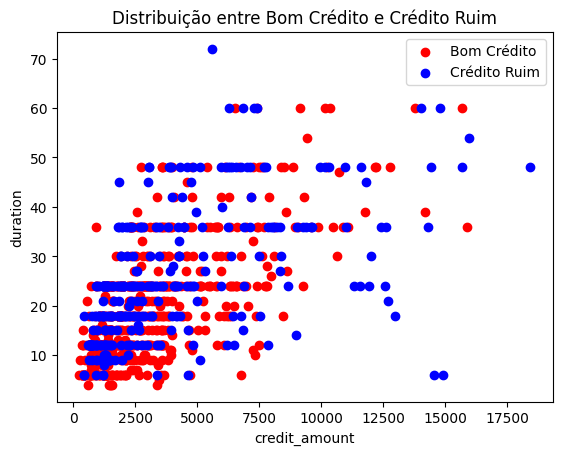

In [8]:
# escolhendo duas colunas significantes
x_column = 'credit_amount'  # coluna numérica para o eixo x
y_column = 'duration'  # coluna numérica para o eixo y
label_column = 'class'       # coluna de rótulos

# filtrando os dados para os rótulos desejados
filtered_data = df_lin[df_lin[label_column].isin([1, 0])]

# dividindo os dados por rótulo
label_1_data = filtered_data[filtered_data[label_column] == 1]
label_2_data = filtered_data[filtered_data[label_column] == 0]

# criando o scatter plot
plt.scatter(label_1_data[x_column], label_1_data[y_column], color='red', label='Bom Crédito')
plt.scatter(label_2_data[x_column], label_2_data[y_column], color='blue', label='Crédito Ruim')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('Distribuição entre Bom Crédito e Crédito Ruim')
plt.legend()
plt.show()


### Modelagem & Performance

In [9]:
X = df_lin[['status_account', 'credit_history', 'savings_account', 'present_employment', 'other_installment_plans',
            'age', 'personal_status', 'foreign_worker', 'number_credits', 'telephone']].values

y = df_lin['class'].values

In [10]:
# normalizando dados para que o treinamento do modelo não seja afetado por outliers
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# criando modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

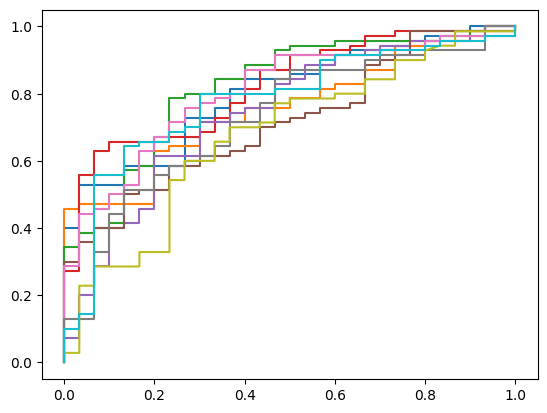

In [12]:
# criando a configuração do StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# precisarei depois para a matriz de confusão e a curva roc
number_of_classes = len(np.unique(y))
y_pred = [] # labels preditos, utilizado para cálculo de métricas
y_pred_proba = [] # probabilidades preditas, o que se deseja extrair
y_true = []
  
# realiza o treinamento e teste do modelo usando os índices dos folds obtidos pelo skf.split(x, y)
for train_index, test_index in skf.split(X, y):
  # obtendo amostras de teste e treinamento a partir do índice dos folds
  X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
  y_train_fold, y_test_fold = y[train_index], y[test_index]

  # treinamento do modelo com suas correspondentes amostras
  model.fit(X_train_fold, y_train_fold)

  # fazendo predição do modelo na amostra de teste e adicionando os resultados em uma lista 
  y_pred.extend(model.predict(X_test_fold))

  # obtendo as probabilidades de cada classe para cada amostra de teste
  fold_proba = model.predict_proba(X_test_fold)[:,1] # probabilidade da ser bom pagador(1)
  y_pred_proba.extend(fold_proba) # adicionando na lista de probs preditas
  
  # preenchendo a lista com todas as amostras de teste
  y_true.extend(y_test_fold)

  # calculando a curva ROC para cada classe e a AUC
  fpr, tpr, _ = roc_curve(y_test_fold, fold_proba, pos_label=1)
  roc_auc = auc(fpr, tpr)

  # plotando a curva ROC para cada fold
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

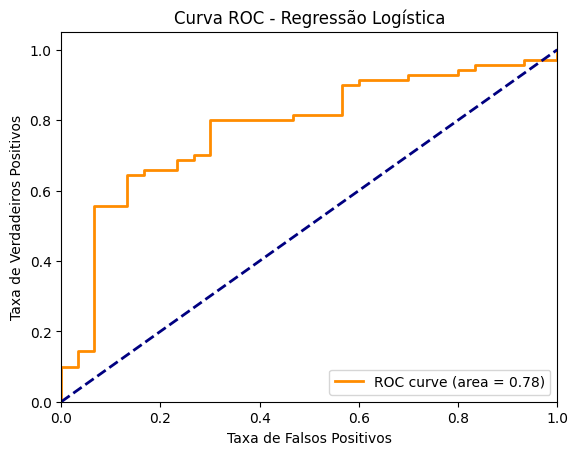

In [13]:
# plotando a curva ROC para todos os folds
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.show()

In [14]:
# MÉTRICAS DE PERFORMANCE
acc = mean(cross_val_score(model, X, y, scoring='accuracy', cv=skf, n_jobs=-1))
precision = mean(cross_val_score(model, X, y, scoring='precision', cv=skf, n_jobs=-1))
recall = mean(cross_val_score(model, X, y, scoring='recall', cv=skf, n_jobs=-1))
f1_score = mean(cross_val_score(model, X, y, scoring='f1', cv=skf, n_jobs=-1))
roc_auc = mean(cross_val_score(model, X, y, scoring='roc_auc', cv=skf, n_jobs=-1))

print(f"Acurácia: {acc:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"ROC-Auc: {roc_auc:.2f}")

Acurácia: 0.73
Precisão: 0.76
Recall: 0.88
F1-Score: 0.82
ROC-Auc: 0.76


In [15]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
number_of_instances = len(df_lin)
print("Matriz de Confusão:")
print(f"  TN: {tn/number_of_instances:.2f}  FP: {fp/number_of_instances:.2f}")
print(f"  FN: {fn/number_of_instances:.2f}  TP: {tp/number_of_instances:.2f}")

Matriz de Confusão:
  TN: 0.11  FP: 0.19
  FN: 0.08  TP: 0.62


In [16]:
# passando as probabilidades para o dataframe
df_lin["pred_proba"] = y_pred_proba

### Análise de Resultados

In [17]:
df_lin

,status_account,duration,credit_history,purpose,credit_amount,savings_account,present_employment,installment_rate,personal_status,other_debtors,...,age,other_installment_plans,housing,number_credits,job,dependents,telephone,foreign_worker,class,pred_proba
0,0.0,6,4.0,4.0,1169,4.0,4.0,4,2.0,0.0,...,67,2.0,1.0,2,2.0,1,1.0,0.0,1,0.600968
1,1.0,48,2.0,4.0,5951,0.0,2.0,2,1.0,0.0,...,22,2.0,1.0,1,2.0,1,0.0,0.0,0,0.805945
2,3.0,12,4.0,7.0,2096,0.0,3.0,2,2.0,0.0,...,49,2.0,1.0,1,1.0,2,0.0,0.0,1,0.854024
3,0.0,42,2.0,3.0,7882,0.0,3.0,2,2.0,2.0,...,45,2.0,2.0,1,2.0,2,0.0,0.0,1,0.834921
4,0.0,24,3.0,0.0,4870,0.0,2.0,3,2.0,0.0,...,53,2.0,2.0,2,2.0,2,0.0,0.0,0,0.584734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,12,2.0,3.0,1736,0.0,3.0,3,1.0,0.0,...,31,2.0,1.0,1,1.0,1,0.0,0.0,1,0.691580
996,0.0,30,2.0,1.0,3857,0.0,2.0,4,0.0,0.0,...,40,2.0,1.0,1,3.0,1,1.0,0.0,1,0.538349
997,3.0,12,2.0,4.0,804,0.0,4.0,4,2.0,0.0,...,38,2.0,1.0,1,2.0,1,0.0,0.0,1,0.612547
998,0.0,45,2.0,4.0,1845,0.0,2.0,4,2.0,0.0,...,23,2.0,2.0,1,2.0,1,1.0,0.0,0,0.447436


Há clientes classificados como 1 com probabilidade menor de ser bom pagador do que outros que estão classificados como 0. 
Os rótulos desbalanceados atrapalham um pouco a acurácia e outros fatores ainda não identificados também contribuem para esse resultado não muito adequado.

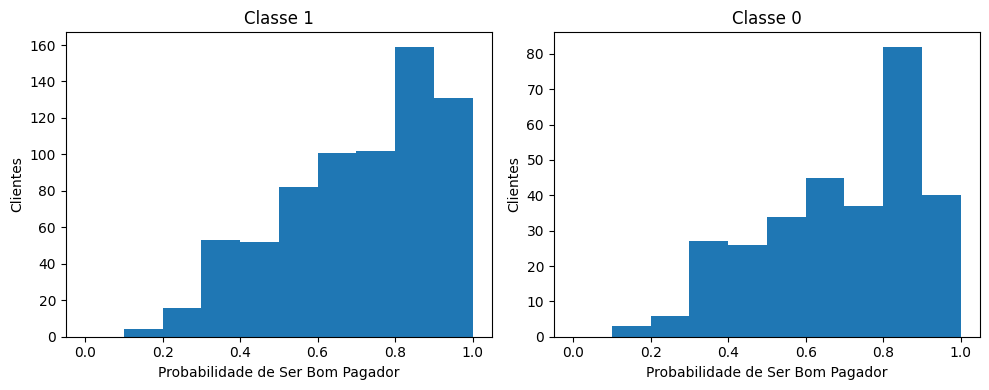

In [18]:
# quebra da probabilidade de ser um bom pagador para cada um dos rótulos.
fig, (hist1, hist2) = plt.subplots(1, 2, figsize=(10, 4))

hist1.hist(df_lin[df_lin['class'] == 1]['pred_proba'], bins=np.arange(0.0, 1.1, 0.1))
hist1.set_xlabel('Probabilidade de Ser Bom Pagador')
hist1.set_ylabel('Clientes')
hist1.set_title('Classe 1')

hist2.hist(df_lin[df_lin['class'] == 0]['pred_proba'], bins=np.arange(0.0, 1.1, 0.1))
hist2.set_xlabel('Probabilidade de Ser Bom Pagador')
hist2.set_ylabel('Clientes')
hist2.set_title('Classe 0')

plt.tight_layout()
plt.show()

Para aqueles rotulados como 1, como é de se esperar, há uma concentração maior nas probabilidade mais altas, consideremos acima de 60%.
Contudo, para aqueles rotulados como 0, deveria haver uma maior concentração nas probabilidades menores e o que acontece é que uma parte desses clientes rotulados como maus pagadores se concentraram na barra de 90% de probabilidade de ser bom pagador e em probabilidades altas no geral.

Por conta da base de dados ser muito pequena, não pareceu adequado usar as técnicas de reamostragem oversampling e undersampling. A primeira, porque poderia causar um overfitting no modelo ao criar amostras demais e se ajustar muito aos dados de treinamento, sem qualidade de generalização, e porque poderia enviesar o resultado da modelagem ao tentar tornar a classe minoritária mais relevante nos resultados. E a segunda, porque ao retirar da base instâncias da classe majoritária para tentar tornar a base mais equilibrada, seriam perdidos dados relevantes para a modelagem.

Além disso, ao colocar o hiperparâmetro *class_weight='balanced'* na definição do modelo, obteve-se uma performance com qualidade inferior e por isso ele foi retirado das configurações do modelo.



### Conclusão

Considerando os resultados obtidos e sua análise, pode-se dizer que o modelo teve um desempenho com acurácia aceitável para um problema de risco de crédito. É esperado que as classes num problema de risco estejam desbalanceadas, sendo a classe de bons pagadores (1) a majoritária, felizmente. Ao tentar ajustar o modelo para que a acurácia seja elevada, o modelo tenderia a ser "otimista" e identificar mais os bons exemplos (já que são a classe predominante) e perderia um pouco da sua capacidade de identificar maus pagadores, o que é justamente o objetivo de um problema de risco. Nos indicando, portanto, que a acurácia por si só pode ser enganosa.

Então faz sentido manter um modelo com acurária um pouco abaixo, mas ainda boa, e analisar o conjunto das demais métricas calculadas: precisão, recall, f1-Score e curva ROC. Elas estão muito agradáveis nesta modelagem.

In [19]:
# criando os filtros para cada perfil definido de cliente
bom_pagador = (df_lin['pred_proba'] >= 0.6) & (df_lin['class'] == 1)
pagador_em_analise = (df_lin['pred_proba'] <= 0.6) & (df_lin['class'] == 1) | (df_lin['pred_proba'] >= 0.6) & (df_lin['class'] == 0)
mau_pagador = (df_lin['pred_proba'] <= 0.6) & (df_lin['class'] == 0)

# criando subsets da base original com a aplicação dos filtros
df_bom_pagador = df_lin.loc[bom_pagador]
df_pagador_em_analise = df_lin.loc[pagador_em_analise] 
df_mau_pagador = df_lin.loc[mau_pagador]

# impressão da contagem de clientes em cada status de crédito
print("Bom pagador | Concessão de Crédito: ", len(df_bom_pagador))
print("Perfil duvidoso | Crédito em Análise: ", len(df_pagador_em_analise))
print("Mau pagador | Risco de Crédito: ", len(df_mau_pagador))

Bom pagador | Concessão de Crédito:  493
Perfil Duvidoso | Crédito em Análise:  411
Mau pagador | Risco de Crédito:  96


Tendo isso em vista, a filtragem dos bons pagadores vai depender dos requisitos determinados por cada negócio. No caso desta análise, como exemplo, estabeleceremos que os bons pagadores são aqueles rotulado como 1 e com probabilidade maior ou igual a 60% de ser bom pagador. Já aqueles rotulados como 1, mas que têm probabilidade menor do que 60% e os rotulado como 0 e com probabilidade maior ou igual a 60% são considerados intermediários e o crédito pode ser concedido a depender do valor e da duração do crédito, além de segunda etapa de análise do histórico desse cliente. E os demais, classificados como 0 e abaixo de 60% de probabilidade de ser bom pagador, são definitivamente maus pagadores.

# Bibliografia

* [UCI Machine Learning Repository. Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))
* [Medium. Dados Desbalanceados — O Que São e Como Lidar Com Eles](https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b)
* [Analytics Vidhya. Top 7 Cross-Validation Techniques](https://www.analyticsvidhya.com/blog/2021/11/top-7-cross-validation-techniques-with-python-code/)